In [1]:
import pandas as pd
df_reasoning = pd.read_parquet("hf://datasets/livebench/reasoning/data/test-00000-of-00001.parquet")
df_math = pd.read_parquet("hf://datasets/livebench/math/data/test-00000-of-00001.parquet")
df_coding = pd.read_parquet("hf://datasets/livebench/coding/data/test-00000-of-00001.parquet")
df_language = pd.read_parquet("hf://datasets/livebench/language/data/test-00000-of-00001.parquet")
df_data_analysis = pd.read_parquet("hf://datasets/livebench/data_analysis/data/test-00000-of-00001.parquet")
df_instruction = pd.read_parquet("hf://datasets/livebench/instruction_following/data/test-00000-of-00001.parquet")

In [2]:
df_reasoning.to_csv('reasoning_dev.csv', index=False)
df_math.to_csv('math.csv_dev', index=False)
df_language.to_csv('language_dev.csv', index=False)
df_data_analysis.to_csv('data_analysis_dev.csv', index=False)
df_instruction.to_csv('instruction_dev.csv', index=False)
# df_coding.to_csv('df_coding.csv', index=False)

In [3]:
print(df_reasoning.shape)
print(df_math.shape)
print(df_coding.shape)
print(df_language.shape)
print(df_data_analysis.shape)
print(df_instruction.shape)

(150, 5)
(232, 9)
(88, 13)
(140, 10)
(150, 5)
(200, 7)


In [4]:
import os

dev_folder_path = '/kaggle/working/dev'
os.makedirs(dev_folder_path, exist_ok=True)

In [5]:
import os
import shutil

source_folder = '/kaggle/working/'
destination_folder = '/kaggle/working/dev'

files = os.listdir(source_folder)
csv_files = [file for file in files if file.endswith('.csv')]

for file in csv_files:
    source_file_path = os.path.join(source_folder, file)
    destination_file_path = os.path.join(destination_folder, file)
    shutil.move(source_file_path, destination_file_path)
    print(f"Moved '{file}' to '{destination_folder}'")

Moved 'instruction_dev.csv' to '/kaggle/working/dev'
Moved 'reasoning_dev.csv' to '/kaggle/working/dev'
Moved 'language_dev.csv' to '/kaggle/working/dev'
Moved 'data_analysis_dev.csv' to '/kaggle/working/dev'


In [6]:
!pip install transformers bitsandbytes sentencepiece accelerate guidance --upgrade -qq

In [7]:
from huggingface_hub import notebook_login
notebook_login()

In [8]:
!pip install --upgrade transformers -qq
!pip install accelerate
!pip install -q -U google-generativeai
!pip install --upgrade transformers -qq
!pip install accelerate
!pip install groq
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00


In [9]:
import torch
import numpy as np
from sklearn.isotonic import IsotonicRegression
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline
from transformers import BitsAndBytesConfig
import torch.nn.functional as F
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
import google.generativeai as genai
from bert_score import score
import os
from groq import Groq
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import json
import re
import concurrent.futures
from tqdm import tqdm
from yaml import safe_load

import os
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

2024-06-25 09:55:21.549497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 09:55:21.549610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 09:55:21.677746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
client = Groq(api_key="")

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What is the meaning of life? How modern Ai is affeting the real life and what will be the Ai outcomes in future?",
        }

    ],
    model="llama3-70b-8192",
)

print(chat_completion.choices[0].message.content)

**What is the meaning of life?**

The meaning of life is a question that has puzzled philosophers, scientists, and humanity for centuries. There is no one definitive answer, as it varies depending on cultural, religious, and personal beliefs. However, here are some possible perspectives:

1. **Biological perspective**: From a biological standpoint, the meaning of life could be to survive, reproduce, and pass on one's genes to the next generation, ensuring the continuation of the species.
2. **Evolutionary perspective**: According to evolutionary theory, the meaning of life could be to adapt to one's environment, evolve, and become more complex, leading to the development of more advanced forms of life.
3. **Philosophical perspective**: Philosophers have offered various answers, such as:
	* **Hedonism**: The pursuit of pleasure and happiness is the primary goal of life.
	* **Eudaimonia**: The cultivation of virtues and living a life of flourishing and fulfillment is the key to a meaning

In [11]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


os.environ['GOOGLE_API_KEY']=""
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

gemini_model = genai.GenerativeModel('gemini-pro')

In [12]:
def preprocess_text(text):
    text = str(text)
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

In [11]:
def extract_question_from_prompt(prompt):
    if prompt:
        for element in prompt:
            if "Question: " in element:
                question_part = element.split("Question: ")[1] 
                if "Answer: " in question_part: 
                    return question_part.split("Answer:")[0].strip()
                else:  # Handle cases where "Answer: " is not present
                    return question_part.strip()
    else:
        return "" 

## Class pipeline for livebench dataset

In [13]:
class Tokenizer:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def encode(self, text, max_length=1024):
        return self.tokenizer.encode_plus(text, return_tensors='pt', max_length=max_length, truncation=True)

    def decode(self, tokens):
        return self.tokenizer.decode(tokens, skip_special_tokens=True)

In [ ]:
self.categories = {
            "df_math": ["math"],
            "df_coding": ["coding"],
            "df_data_analysis": ["data_analysis"],
            "df_instruction": ["instruction"],
            "df_language": ["language"],
            "df_reasoning": ["reasoning"],
        }


def judge_answer(self, response, prompt):
        evaluation_prompt =  f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
        judge_response = gemini_model.generate_content(evaluation_prompt)
        return judge_response

In [26]:
  class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300, num_questions=None):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.num_questions = num_questions


        self.tokenizer = Tokenizer(smaller_model_name)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "data_analysis": ["data_analysis"],
            "instruction": ["instruction"],
            "language": ["language"],
            "reasoning": ["reasoning"],
        }

    def get_model_answer(self, prompt):
        """Generates an answer from the specified model."""
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            max_new_tokens=300,  # Limit the number of generated tokens
            num_return_sequences=1, 
            temperature=self.temperature, 
            output_scores=True, 
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0])

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def judge_answer(self, response, prompt):
        evaluation_prompt =  f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
        judge_response = gemini_model.generate_content(evaluation_prompt)
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            max_new_tokens=self.max_tokens, 
            num_return_sequences=1, 
            temperature=self.temperature, 
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0])
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path):
        # Clear data before processing each file
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)
        # self.prompts = df.iloc[:, 0].tolist()  # Take only the first column (questions)
        
        # Taking only `num_questions` prompts if specified
        if self.num_questions:
            df = df.sample(n=self.num_questions, random_state=42)
        self.prompts = df["turns"].tolist()

        for prompt in self.prompts:
            response, confidence = self.get_model_answer(prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)  # Save results to CSV
        return data, bins, bin_accuracies

    def evaluate_folder(self, folder_path):
        results = {}  # Store ECE values for each class
        category_results = {category: [] for category in set(cat for sublist in self.categories.values() for cat in sublist)}

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8]  # Extract class name from filename without "_dev.csv"
                
                category_name = None
                for key, value in self.categories.items():
                    if key == class_name:
                        category_name = value[0]
                        break
            
                if category_name:
                    print(f"Evaluating {class_name} in category {category_name}...")
                    data, bins, bin_accuracies = self.evaluate_from_csv(filepath)

                    # Align shapes and calculate ECE
                    bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                    valid_bins = bin_accuracies.dropna().index  # Bins with data
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                    bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

        # Calculate average ECE for each category and save to CSV
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)
        
        # Plot the Reliability Diagram for each category
        fig, axs = plt.subplots(len(category_results), 1, figsize=(8, 4 * len(category_results)))
        fig.suptitle("Reliability Diagrams for Different Categories")

        for i, (category, ece_list) in enumerate(category_results.items()):
            ax = axs[i]
            ax.set_title(f"Category: {category}")
            ax.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
            for class_name, data, bins, bin_accuracies in results.items():
                if self.categories.get(class_name)[0] == category:
                    bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                    valid_bins = bin_accuracies.dropna().index
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]
                    bin_confidences = bin_confidences[valid_bins]
                    ax.plot(bin_confidences, bin_accuracies, marker='o', label=class_name)

            ax.set_xlabel("Confidence")
            ax.set_ylabel("Accuracy")
            ax.legend()

        plt.tight_layout()
        plt.show()

    def calculate_ece(self):
        # Ensure all lists have the same length
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        # Drop bins with NaN values
        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        # Ensure lengths match
        bin_confidences = bin_confidences[:len(bin_accuracies)]

        # Compute ECE
        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Evaluating instruction in category instruction...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.

BERTScore - Precision: 0.9398477077484131, Recall: 0.9433956146240234, F1: 0.9416093826293945
Expected Calibration Error (ECE): 0.95
instruction ECE: 0.95
Evaluating reasoning in category reasoning...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.

BERTScore - Precision: 0.9313514828681946, Recall: 0.8982365727424622, F1: 0.9138045310974121
Expected Calibration Error (ECE): 0.95
reasoning ECE: 0.95
Evaluating language in category language...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.

BERTScore - Precision: 0.9661464095115662, Recall: 0.9447040557861328, F1: 0.9550271034240723
Expected Calibration Error (ECE): 0.9166666666666666
language ECE: 0.9166666666666666
Evaluating data_analysis in category data_analysis...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


BERTScore - Precision: 0.9990077018737793, Recall: 0.9985661506652832, F1: 0.9987867474555969
Expected Calibration Error (ECE): 0.95
data_analysis ECE: 0.95


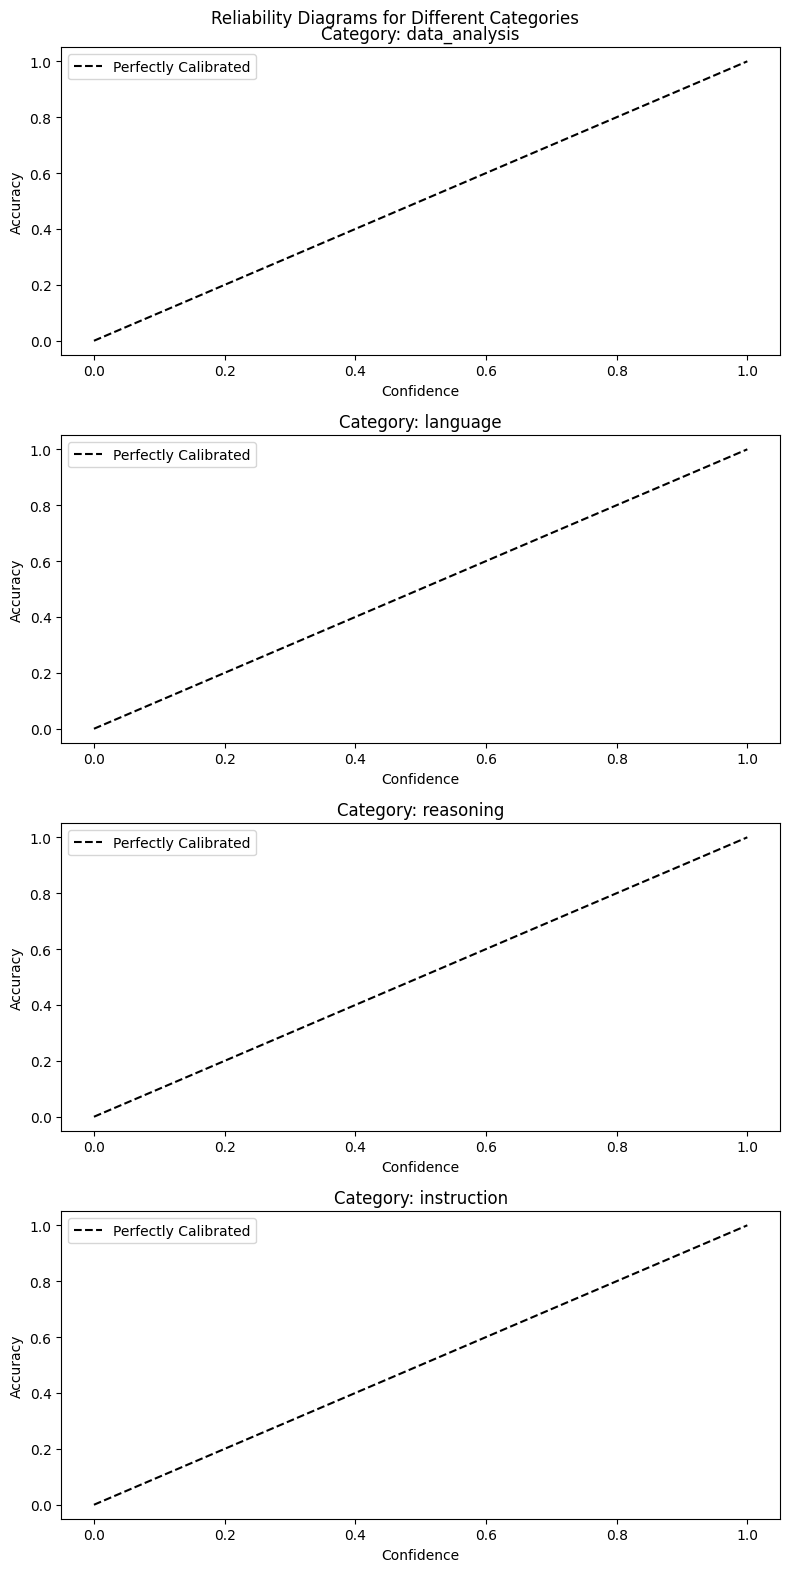

In [27]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name="mistralai/Mistral-7B-Instruct-v0.2", num_questions=3)
pipeline.evaluate_folder("/kaggle/working/dev")

## Reliability 

In [29]:
  class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300, num_questions=None):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.num_questions = num_questions


        self.tokenizer = Tokenizer(smaller_model_name)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "data_analysis": ["data_analysis"],
            "instruction": ["instruction"],
            "language": ["language"],
            "reasoning": ["reasoning"],
        }

    def get_model_answer(self, prompt):
        """Generates an answer from the specified model."""
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            max_new_tokens=300,  # Limit the number of generated tokens
            num_return_sequences=1, 
            temperature=self.temperature, 
            output_scores=True, 
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0])

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def judge_answer(self, response, prompt):
        evaluation_prompt =  f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
        judge_response = gemini_model.generate_content(evaluation_prompt)
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            max_new_tokens=self.max_tokens, 
            num_return_sequences=1, 
            temperature=self.temperature, 
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0])
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path):
        # Clear data before processing each file
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)
        # self.prompts = df.iloc[:, 0].tolist()  # Take only the first column (questions)
        
        # Taking only `num_questions` prompts if specified
        if self.num_questions:
            df = df.sample(n=self.num_questions, random_state=42)
        self.prompts = df["turns"].tolist()

        for prompt in self.prompts:
            response, confidence = self.get_model_answer(prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)  # Save results to CSV
        return data, bins, bin_accuracies

    def evaluate_folder(self, folder_path):
        results = {}  # Store ECE values for each class
        category_results = {category: [] for category in set(cat for sublist in self.categories.values() for cat in sublist)}
        reliability_data = {}

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8]  # Extract class name from filename without "_dev.csv"
                
                category_name = None
                for key, value in self.categories.items():
                    if key == class_name:
                        category_name = value[0]
                        break
            
                if category_name:
                    print(f"Evaluating {class_name} in category {category_name}...")
                    data, bins, bin_accuracies = self.evaluate_from_csv(filepath)
                    
                    # Store class-wise data for reliability diagram
                    reliability_data[class_name] = {
                        'bin_confidences': (bins[:-1] + bins[1:]) / 2,
                        'bin_accuracies': bin_accuracies
                    }

                    # Align shapes and calculate ECE
                    bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                    valid_bins = bin_accuracies.dropna().index  # Bins with data
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                    bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

        # Calculate average ECE for each category and save to CSV
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)
        
        # Plot reliability diagram for all classes in one figure
        plt.figure(figsize=(10, 6))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Find the maximum number of bins across all classes
        max_bins = max([len(data['bin_accuracies']) for data in reliability_data.values()])

        # Pad bin_accuracies with NaN to ensure equal lengths for plotting
        for class_name, data in reliability_data.items():
            num_missing_bins = max_bins - len(data['bin_accuracies'])
            data['bin_accuracies'] = np.pad(data['bin_accuracies'], (0, num_missing_bins), 'constant', constant_values=np.nan)

            plt.scatter(data['bin_confidences'][:max_bins], data['bin_accuracies'], label=class_name, s=50)

        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')
        plt.title('Reliability Diagram for All Classes')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_ece(self):
        # Ensure all lists have the same length
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        # Drop bins with NaN values
        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        # Ensure lengths match
        bin_confidences = bin_confidences[:len(bin_accuracies)]

        # Compute ECE
        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Evaluating instruction in category instruction...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.

BERTScore - Precision: 0.9475005269050598, Recall: 0.954753577709198, F1: 0.951108455657959
Expected Calibration Error (ECE): 0.95
instruction ECE: 0.95
Evaluating reasoning in category reasoning...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.

BERTScore - Precision: 0.9173522591590881, Recall: 0.8859882950782776, F1: 0.9011211395263672
Expected Calibration Error (ECE): 0.95
reasoning ECE: 0.95
Evaluating language in category language...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.

BERTScore - Precision: 0.959860622882843, Recall: 0.9500858187675476, F1: 0.9548840522766113
Expected Calibration Error (ECE): 0.9166666666666666
language ECE: 0.9166666666666666
Evaluating data_analysis in category data_analysis...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


BERTScore - Precision: 0.9990077018737793, Recall: 0.9985661506652832, F1: 0.9987867474555969
Expected Calibration Error (ECE): 0.95
data_analysis ECE: 0.95


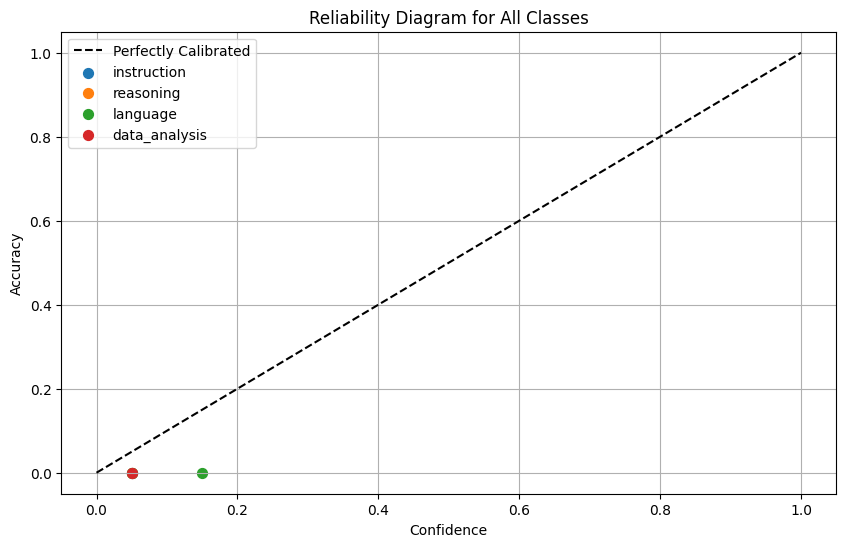

In [30]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name="mistralai/Mistral-7B-Instruct-v0.2", num_questions=3)
pipeline.evaluate_folder("/kaggle/working/dev")

In [31]:
import shutil

folder_path = '/kaggle/working/test'
os.makedirs(folder_path, exist_ok=True)

source_path = '/kaggle/working/dev/reasoning_dev.csv'
destination_path = '/kaggle/working/test/reasoning_dev.csv'

# Move file
shutil.copy(source_path, destination_path)

'/kaggle/working/test/reasoning_dev.csv'

In [35]:
  class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300, num_questions=None):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.num_questions = num_questions


        self.tokenizer = Tokenizer(smaller_model_name)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "data_analysis": ["data_analysis"],
            "instruction": ["instruction"],
            "language": ["language"],
            "reasoning": ["reasoning"],
        }

    def get_model_answer(self, prompt):
        """Generates an answer from the specified model."""
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            max_new_tokens=300,  # Limit the number of generated tokens
            num_return_sequences=1, 
            temperature=self.temperature, 
            output_scores=True, 
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0])

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def judge_answer(self, response, prompt):
        evaluation_prompt =  f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
        judge_response = gemini_model.generate_content(evaluation_prompt)
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            max_new_tokens=self.max_tokens, 
            num_return_sequences=1, 
            temperature=self.temperature, 
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0])
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path):
        # Clear data before processing each file
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)
        # self.prompts = df.iloc[:, 0].tolist()  # Take only the first column (questions)
        
        # Taking only `num_questions` prompts if specified
        if self.num_questions:
            df = df.sample(n=self.num_questions, random_state=42)
        self.prompts = df["turns"].tolist()

        for prompt in self.prompts:
            response, confidence = self.get_model_answer(prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)  # Save results to CSV
        return data, bins, bin_accuracies

    def evaluate_folder(self, folder_path):
        results = {}  # Store ECE values for each class
        category_results = {category: [] for category in set(cat for sublist in self.categories.values() for cat in sublist)}
        reliability_data = {}

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8]  # Extract class name from filename without "_dev.csv"
                
                category_name = None
                for key, value in self.categories.items():
                    if key == class_name:
                        category_name = value[0]
                        break
            
                if category_name:
                    print(f"Evaluating {class_name} in category {category_name}...")
                    data, bins, bin_accuracies = self.evaluate_from_csv(filepath)
                    
                    # Store class-wise data for reliability diagram
                    reliability_data[class_name] = {
                        'bin_confidences': (bins[:-1] + bins[1:]) / 2,
                        'bin_accuracies': bin_accuracies
                    }

                    # Align shapes and calculate ECE
                    bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                    valid_bins = bin_accuracies.dropna().index  # Bins with data
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                    bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

        # Calculate average ECE for each category and save to CSV
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)
        
        # Plot reliability diagram for all classes in one figure
        plt.figure(figsize=(10, 6))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Find the maximum number of bins across all classes
        max_bins = max([len(data['bin_accuracies']) for data in reliability_data.values()])

        # Pad bin_accuracies with NaN to ensure equal lengths for plotting
        for class_name, data in reliability_data.items():
            num_missing_bins = max_bins - len(data['bin_accuracies'])
            data['bin_accuracies'] = np.pad(data['bin_accuracies'], (0, num_missing_bins), 'constant', constant_values=np.nan)

            plt.scatter(data['bin_confidences'][:max_bins], data['bin_accuracies'], label=class_name, s=50)

        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')
        plt.title('Reliability Diagram for All Classes')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_ece(self):
        # Ensure all lists have the same length
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        # Drop bins with NaN values
        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        # Ensure lengths match
        bin_confidences = bin_confidences[:len(bin_accuracies)]

        # Compute ECE
        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

In [ ]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name="mistralai/Mistral-7B-Instruct-v0.2")
pipeline.evaluate_folder("/kaggle/working/test")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Evaluating reasoning in category reasoning...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end